# **Building a Neural Network from Scratch**
The goal of this tutorial is to outline the necessary steps to build an Artificial Neural Network (ANN) from the ground up, explaining in theory the various elements required for its construction, training, and practical application. To achieve this, we will implement a Feedforward Neural Network, where information flows from the network's input layers, stimulating the network's neurons, and producing an output.

The following topics will be covered:

# **Table of Contents**
- [1 - Environment Preparation](#1)
- [2 - Layer Initialization](#2)
- [3 - Parameter Initialization](#3)
- [4 - Implementing Forward Propagation](#4)
- [5 - Cost Computation](#5)
- [6 - Implementing Backward Propagation](#6)
- [7 - Parameter Update (Gradient Descent)](#7)
- [8 - Model Training](#8)
- [9 - Prediction](#9)

<a name='1'></a>
# **1.- Environment Setup**
First, all the necessary libraries for the implementation are installed and imported.

## 1.1.- Library Installation
Primarily, `numpy` and `matplotlib` will be used for some visualizations:

In [1]:
%%capture
%pip install numpy
%pip install matplotlib
%pip install --upgrade jupyter
%pip install --upgrade notebook
%pip install jupyterlab

Before proceeding with the construction of the neural network, it is important to check that the GPU is available for use. To do this, the following function from the `Tensorflow` library can be used:

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-08-29 16:04:44.063003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 16:04:44.175236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 16:04:44.207161: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 16:04:44.414708: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


I0000 00:00:1724947487.557571     630 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724947487.639426     630 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724947487.639471     630 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.


We can see that a graphics card is reported as available.

## 1.2.- Libraries Initalization
Once installed, the libraries are initialized:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

os.chdir('/app/functions')

# I will also import activation functions, which are crucial for correct working of the net
from activation_functions import relu, sigmoid, sigmoid_backward, relu_backward

os.chdir('/app/notebooks')

## 1.3.- Loading the Dataset
For training the neural network, we will use the CIFAR-10 dataset. This dataset consists of 60,000 color images, each of size 32x32, categorized into 10 classes (with 6,000 images per class). The data is divided into 50,000 training images and 10,000 test images. The classes are: 'Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck'.

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

By extracting the images from the TensorFlow library, we will distinguish between the training dataset (x_train) and its corresponding labels (y_train), and the test data. However, to input the images into our neural network, all images need to be flattened (into a single vector) and standardized.

Moreover, since the objective is to solve a binary classification task, we will filter for only 2 classes. We will focus on distinguishing between 'Truck' and 'Frog'.

In [5]:
# Filtering training and test data
train_indices = np.where((y_train == 9) | (y_train == 6))[0]
x_train = x_train[train_indices]
y_train = y_train[train_indices]
y_train = np.where(y_train == 9, 0, 1)

test_indices = np.where((y_test == 9) | (y_test == 6))[0]
x_test = x_test[test_indices]
y_test = y_test[test_indices]
y_test = np.where(y_test == 9, 0, 1)

# Flattening the training and test images
x_train_flattened = x_train.reshape(x_train.shape[0], -1).T
x_test_flattened = x_test.reshape(x_test.shape[0], -1).T

# Standardizing the pixels
x_train_flattened_standardized = x_train_flattened / 255.0
x_test_flattened_standardized = x_test_flattened / 255.0

# Displaying the new dimensions of the images
print("TRAIN - The dimensions of the images are now ", str(x_train_flattened_standardized.shape))
print("TEST - The dimensions of the images are now ", str(x_test_flattened_standardized.shape))

TRAIN - The dimensions of the images are now  (3072, 10000)
TEST - The dimensions of the images are now  (3072, 2000)


Knowing the size of the dataset, I visualize an initial example of the data:

In [6]:
def visualize_image(dataset, index_image):
    plt.figure(figsize=(5,5))
    
    # Remove axis labels
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(dataset[index_image])
    plt.show()

Let's use the method:

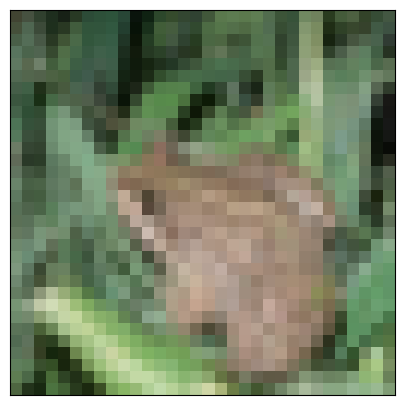

In [7]:
visualize_image(x_test, 0)

<a name='2'></a>
# **2.- Initialization of Layers**
First, some parameters of the network must be decided, which will allow us to create its architecture. These parameters include the number of hidden layers and the number of neurons in each layer.

In [8]:
def init_layers(X, Y, num_hidden_layers, num_hidden_units):
    """_summary_
    This method defines the structure of the neural network by specifying the number of neurons in the input layer (which is determined by the size of the dataset used),
    the number of hidden layers specified by an input parameter, the number of neurons in each of these hidden layers, and finally, the number of neurons in the output layer 
    (determined by the size of the target variable).

    It is understood that this is building a Deep Neural Network where all hidden layers have the same number of neurons.

    Args:
        X (class 'numpy.ndarray'): input dataset (input size, number of examples)
        Y (class 'numpy.ndarray'): labels (output size, number of examples)
        num_hidden_layers (class 'int'): number of hidden layers of the network
        num_hidden_units (class 'list'): list containing number of nodes per layer.    
    
    Returns:
        dim_layers (class 'list'): list containing number of nodes per layer, incluiding input and output layers.
    """

    # Define an array to store the network layer structure
    dim_layers = []

    # Define the number of neurons in the input layer
    input_units = X.shape[1]*X.shape[2]*X.shape[3]

    # Add the first layer, in this case, the input layer
    dim_layers.append(input_units)

    # Iterate over the number of hidden layers
    for i in range(0,num_hidden_layers):
        dim_layers.append(num_hidden_units[i])

    # Finally, add the output layer
    output_units = Y.shape[1]
    dim_layers.append(output_units)

    return dim_layers

We use the method to initialize the network structure:

In [9]:
rna = init_layers(X = x_train, Y = y_train, num_hidden_layers = 3, num_hidden_units = [2000, 800, 100])

<a name='3'></a>
# **3.- Parameter Initialization**
This method allows us to initialize the parameters for a neural network with `l` layers. Both weights and biases will be initialized using this method. Dimensions will be as follows:
$$Weights, W = (n^{[l]}, n^{[l-1]})$$
$$Bias, b = (n^{[l]}, 1)$$
This means, Weights matrix will have one row for every node in the layer initialized and one column for every node of the previous layer. What about the first layer? Well, we'll have:
* ${n^{[l]} = }$ num. of nodes in the actual layer.
* ${n^{[l-1]} = }$ num. of pixels in input images.

Also, what about the values? Well:

* $Weights, W$: it is important to initialize all weights to small random values. The technique used in this example is the `He Initialization`, that takes into account the non-linearity of activation functions, reducing the magnitudes of input signals exponentially. In this initialization method, we'll multiply small random values with $\sqrt{\frac{2}{\text{dimension of the previous layer}}}$, which is what He initialization recommends for layers with a ReLU activation.

* $Bias, b$: these can be initialized with small random positive values or zeros. In this example, we've used zeros.

In [10]:
import numpy as np

def init_parameters(dims_layers):
    """_summary_
    This function initializes the parameters of the Neural Network based on the structure defined in the previous function.

    Args:
        dims_layers (class 'list'): list containing number of nodes per layer, incluiding input and output layers.

    Returns:
        parameters (class 'dict'): dictionary consisting of the set of initialized parameters in the network.
    """

    # Create a dictionary to store the parameters
    parameters = {}

    for num_capa in range(1, len(dims_layers)):
        # For each layer, create the corresponding weight matrix and bias.
        parameters['W' + str(num_capa)] = np.random.randn(dims_layers[num_capa], dims_layers[num_capa-1]) * (np.sqrt(2/dims_layers[num_capa-1]))
        parameters['b' + str(num_capa)] = np.zeros((dims_layers[num_capa], 1))

    # Return the initialized parameters
    return parameters

<a name='4'></a>
# **4.- Implementation of 'Forward Propagation'**
To implement forward propagation, the following calculations need to be performed:
* Calculation of the pre-activation parameters.
* Calculation of the activation of the neurons.

## 4.1.- Pre-Activation Parameters
This method calculates the parameters that are input into the neuron's activation function. The equation used is:

$$Z^{[l]} = W^{[l]}A^{[l-1]} + b^{[l]}\$$

where ${[l]}$ denotes the layer number; $W^{[l]}$ represents the current weights of the current layer; $A^{[l-1]}$ is the activation of the previous layer; and $b^{[l]}$ is the bias of the layer.

In [11]:
import numpy as np

def pre_activation(A, W, b):
    """_summary_
    This function calculates the pre-activation parameters of a layer.
    
    Args:
        A (class 'numpy.ndarray'): consists of the activations obtained from the previous layer.
        W (class 'numpy.ndarray'): consists of the current weights of the layer.
        b (class 'numpy.ndarray'): consists of the current bias of the layer.

    Returns:
        Z (class 'numpy.ndarray'): consists of the pre-activation params. obtained.
        pre_activation_params (class 'tuple'): tuple containing A, W, b, stored to speed up network training.
    """

    # Calculate the pre-activation parameters
    Z = np.dot(W,A) + b

    # Create a Python tuple stored in cache to speed up network training, as these parameters will be used later
    pre_activation_params = (A, W, b)

    return Z, pre_activation_params

## 4.2.- Calculation of Layer Activation
Based on the pre-activation parameters calculated earlier, the appropriate activation function must be applied to the resulting matrix. In this case, all hidden layers will use the ReLU activation function, while the output layer will employ the sigmoid function.
$$A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$$
where `g()` can be a Sigmoid or ReLU function: 

In [12]:
def forward_activation(dataset, parameters):
    """_summary_
    Function that computes the activation of a layer.

    Args:
        dataset (class 'numpy.ndarray'): Input data. Used to determine the number of neurons in the input layer.
        parameters (class 'dict'): Python dictionary with the initialized parameters based on the network structure: weights and biases.

    Returns:
        AL (class 'numpy.ndarray'): Activation of the final layer.
        cache (class 'list'): Tuple containing the activation of the previous layer (A_prev), weights of the current layer (W), and bias (b).
    """

    # Store the results in cache to speed up network training
    caches = []

    # Number of hidden layers
    hidden_layers = len(parameters) // 2

    # For the first layer, activation functions are the input data
    A = dataset

    # Compute activation for hidden layers
    for num_layer in range(1, hidden_layers):
        Z, pre_activation_params = pre_activation(A, parameters['W' + str(num_layer)], parameters['b' + str(num_layer)])
        A, cache = relu(Z)
        cache = (pre_activation_params, cache)
        caches.append(cache)
    
    # Compute activation for the final layer
    Z, pre_activation_params = pre_activation(A, parameters['W' + str(hidden_layers)], parameters['b' + str(hidden_layers)])
    AL, cache = sigmoid(Z)
    cache = (pre_activation_params, cache)
    caches.append(cache)
    
    return AL, caches

<a name='5'></a>
# **5.- Computation of Loss**
At this point, the activation of each layer has already been computed, so we just need to compute the cost. The cost defines the error between the model's predictions and the actual labels of the dataset. To ensure that our model is learning correctly, the cost should decrease at each stage of training.

Since we are working with a binary classification problem, we will use binary cross-entropy as the loss function. However, it is important to note that different loss functions can be used depending on the problem being addressed or the metric that is prioritized for optimization.

<!--  -->
$$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \$$


Below is the implementation:

In [15]:
def cost_function(predictions, Y):
    """_summary_
    Function that calculates the error between the model's predictions and the correct labels.

    Args:
        predictions (class 'numpy.ndarray'): network predictions.
        Y (class 'numpy.ndarray'): true labels.

    Returns:
        cost (class 'numpy.float64'): error obtained from network predictions compared to true labels.
    """

    # Calculate the loss function
    cost = - np.mean( Y * np.log(predictions) + (1-Y) * np.log(1-predictions)) 

    cost = np.squeeze(cost) 

    return cost

<a name='6'></a>
# **6.- Implementation of Backward Propagation**

The backpropagation algorithm enables the information about the cost obtained during forward propagation to be propagated backward (in the opposite direction of forward propagation) with the goal of computing the gradient. It is important to distinguish this process from parameter updates, which are carried out by another algorithm, such as stochastic gradient descent.

## 6.1.- Linear backward activation
To implement backward propagation, multiple calculations will be necessary. First, the linear activation, starting from the activation of the last layer:

Having the derivative `dZ`:

$$dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \$$


$$db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)} \$$


$$dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \$$

where `m` is the number of examples of the batch.

In [16]:
def linear_backward(dZ, cache):
    """_summary_
    Function to compute the backward propagation for a single layer.
    
    Args:
        dZ (class 'numpy.ndarray'): Gradient of the cost with respect to the output.
        cache (class 'tuple'): Activation values from the previous layer (A_prev), weights (W), and bias (b) of the current layer.
    
    Returns:
        dA_prev (class 'numpy.ndarray'): derivatives obtained from activations of prev. layer
        dW (class 'numpy.ndarray'): derivatives obtained from weights of actual layer.
        db (class 'numpy.ndarray'): derivatives obtained from bias of actual layer.
    """

    # Retrieve values from the cache
    A_prev, W, b = cache

    # Get the number of examples
    num_examples = A_prev.shape[1]

    # Calculate gradients with respect to W, b, and the activation layer
    dW = (1/num_examples) * np.dot(dZ, np.transpose(A_prev))
    db = (1/num_examples) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(np.transpose(W), dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db

## 6.2.- Implementation of Backward Propagation
Finally, the complete backward propagation method is implemented:

In [17]:
def backward_propagation(dZ, Y, cache):
    """_summary_
    Function that implements 'backward propagation' for a single layer.

    Args:
        dZ (class 'numpy.ndarray'): Gradient of the cost with respect to the output.
        Y (class 'numpy.ndarray'): true labels.
        cache (class 'list'): Tuple containing the activation of the previous layer (A_prev), weights of the current layer (W), and bias (b).

    Return:
        gradients (class 'dict'): Python dictionary containing the gradients for each layer.
    """
    # Initialize the gradient vector
    gradients = {}

    # The number of layers can be determined directly from the number of caches
    num_layers = len(cache)

    Y = Y.reshape(dZ.shape)
    
    # To avoid logarithms and divisions by 0
    epsilon = 1e-15
    AL = np.clip(dZ, epsilon, 1 - epsilon)

    # Initialize backward propagation by calculating the derivative of the final activation layer
    dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Start with the final layer, from which parameters can be obtained using the 'linear_activation_backward' function
    cache_actual = cache[num_layers-1]
    linear_cache, activation_cache = cache_actual
    dZ = sigmoid_backward(dAL, activation_cache)
    dA_prev, dW, db = linear_backward(dZ, linear_cache)
    gradients['dA'+str(num_layers-1)] = dA_prev
    gradients['dW'+str(num_layers)] = dW
    gradients['db'+str(num_layers)] = db

    # Iterate from the last layer to the first, i.e., in reverse order
    for num_layer in reversed(range(num_layers-1)):
        # Retrieve the cache for the layer
        cache_actual = cache[num_layer]
        linear_cache, activation_cache = cache_actual

        # Calculate the backward linear activation
        dZ = relu_backward(gradients['dA'+str(num_layer+1)], activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        gradients['dA'+str(num_layer)] = dA_prev
        gradients['dW'+str(num_layer+1)] = dW
        gradients['db'+str(num_layer+1)] = db

    return gradients

<a name='7'></a>
# **7.- Parameter Update (Gradient Descent)**
Once the backward propagation has been computed for the weights and biases of each layer in the network, the parameters need to be updated using the learning rate. This rate determines how aggressively each parameter will be adjusted.
$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \$$
where $\alpha$ is the parameter learning rate.

In [18]:
import copy

def update_parameters(parameters, gradients, lrate):
    """_summary_
    Function that updates parameters using gradient descent.

    Args:
        parameters (class 'dict'): dictionary consisting of the set of initialized parameters in the network.
        gradients (class 'dict'): Python dictionary containing the gradients for each layer.
        lrate (class 'numpy.float64'): learning rate value.

    Returns:
        params (class 'dict'): dictionary consisting of the set of updated parameters in the network.
    """
    params = copy.deepcopy(parameters)
    
    # Number of hidden layers
    hidden_layers = len(params) // 2
    
    # Update the parameters across the entire network
    for num_layer in range(hidden_layers):
        params["W" + str(num_layer+1)] = params["W" + str(num_layer+1)] - lrate * gradients['dW' + str(num_layer+1)]
        params["b" + str(num_layer+1)] = params["b" + str(num_layer+1)] - lrate * gradients['db' + str(num_layer+1)]
        
    # Return the updated parameters (weights and bias)
    return params

<a name='8'></a>
# **8.- Training the Model**
Finally, the network training process begins. The process of forwarding information through the entire network, calculating gradients, and updating parameters will be repeated for a specified number of iterations: `num_iterations`. The error for each iteration will be returned for both the training set, from which the network learns, and the validation set, which is not used to compute gradients or update parameters. Thus, the network will be evaluated in each iteration with "unseen" data.

In [19]:
def train_model(X, Y, val_x, val_y, model, lrate, num_iterations):
    """_summary_
    Function that optimize the neural network.

    Args:
        X (class 'numpy.ndarray'): training dataset.
        Y (class 'numpy.ndarray'): training labels.
        val_x (class 'numpy.ndarray'): validation dataset.
        val_y (class 'numpy.ndarray'): validation labels.
        model (class 'list'): list containing number of nodes per layer, including input and output layers.
        lrate (class 'numpy.float64'): learning rate value.
        num_iterations (class 'int'): number of training iterations through dataset.

    Returns:
        parameters (class 'dict'): dictionary consisting of the set of updated parameters from the network after training.
        loss_train (class 'list'): list of training error progression throughout optimization.
        loss_val (class 'list'): list of validation error progression throughout optimization.
        error (class 'numpy.float64'): error obtained on the last iteration, which means the error of the network with training dataset.
    """

    gradients = {}
    
    # To store the error after each iteration
    loss_train = []
    loss_val = []

    # Adjust the shape of the labels
    Y = Y.T
    val_y = val_y.T

    # 1.- Initialize the parameters
    parameters = init_parameters(model)

    # 2.- Training iteration
    for i in range(0, num_iterations):
        
        # First, call 'forward_activation'
        AL, cache = forward_activation(X, parameters)
        
        # For validation:
        AL_val, cache_val = forward_activation(val_x, parameters)

        # Adapt the predictions to avoid errors when calculating logarithms
        epsilon = 1e-15
        AL = np.clip(AL, epsilon, 1 - epsilon)
        
        # Compute the current error
        error = cost_function(AL, Y)
        val_error = cost_function(AL_val, val_y)

        # Initialize 'backward propagation'
        gradients = backward_propagation(AL, Y, cache)
        
        # Update the parameters to accelerate training
        parameters = update_parameters(parameters, gradients, lrate)

        # Display the error in the console
        print("Epoch ", i, " --- Training Error: ", error, " --- Val. Error: ", val_error)
        
        # Save the error of the iteration
        loss_train.append(error)
        loss_val.append(val_error)
    
    # Return the network parameters after training
    return parameters, loss_train, loss_val, error

Let's run the method:

In [20]:
parameters, training_loss, validation_loss, error = train_model(x_train_flattened_standardized, y_train, x_test_flattened_standardized, y_test, rna, lrate = 0.01, num_iterations = 200)

Epoch  0  --- Training Error:  0.8500716377865228  --- Val. Error:  0.8587394430667517
Epoch  1  --- Training Error:  0.9853685646688842  --- Val. Error:  0.9939569493006509
Epoch  2  --- Training Error:  0.9232865388896638  --- Val. Error:  0.9370473546154416
Epoch  3  --- Training Error:  0.6806662401270008  --- Val. Error:  0.6865924141118418
Epoch  4  --- Training Error:  0.5890640132622397  --- Val. Error:  0.5960462589282138
Epoch  5  --- Training Error:  0.5556989971423054  --- Val. Error:  0.5619904752815831
Epoch  6  --- Training Error:  0.5324737098186558  --- Val. Error:  0.5391811064577016
Epoch  7  --- Training Error:  0.514620022549121  --- Val. Error:  0.5213964390687288
Epoch  8  --- Training Error:  0.4992835165441495  --- Val. Error:  0.5064654783861438
Epoch  9  --- Training Error:  0.4863913853854665  --- Val. Error:  0.49363671612068827
Epoch  10  --- Training Error:  0.47512206430597237  --- Val. Error:  0.4826864494766095
Epoch  11  --- Training Error:  0.4657924

To evaluate the training, the error reduction across the different stages is displayed:









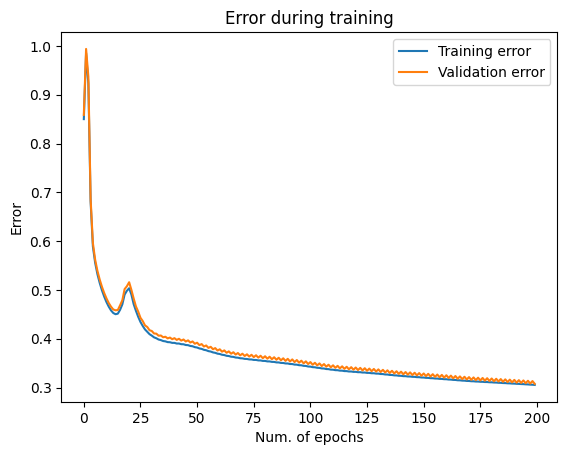

In [21]:
plt.plot(training_loss, label = "Training error")
plt.plot(validation_loss, label = "Validation error")
plt.xlabel("Num. of epochs")
plt.ylabel("Error")
plt.title("Error during training")
plt.legend()
plt.show()

<a name='9'></a>
# **9.- Prediction**
Once the neural network is designed and trained, the main objective is to make predictions with unseen images. To achieve this, we design the method to evaluate the network:

In [22]:
def predict(dataset, parameters, labels):
    # Obtain predictions with the current weights
    predictions, cache = forward_activation(dataset, parameters)

    # Calculate the loss with these predictions
    error = cost_function(predictions, labels)

    return predictions, error

Finally, let's evaluate the ANN with unknown data:

In [24]:
predicciones, error_test = predict(x_test_flattened_standardized, parameters, y_test.T)
print("Error with unknown data: ", error_test)

Error with unknown data:  0.31264615864689455
